# Finetuned Model Testing

This notebook tests our finetuned model from Hugging Face across different recipe categories:
1. Simple recipes
2. High GI recipes
3. Low GI recipes

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from agents.gi_agent_roberta_finetuned import GIAnalysisAgentRoBERTaFinetuned
from agents.gi_agent_roberta_finetuned_2 import GIAnalysisAgentRoBERTaFinetuned2
from agents.gi_grader_agent import GIGraderAgent
from test_data.simple.simple_recipes import SIMPLE_RECIPES
from test_data.high_gi.high_gi_recipes import HIGH_GI_RECIPES
from test_data.low_gi.low_gi_recipes import LOW_GI_RECIPES
import json
from typing import List, Dict, Any
from datetime import datetime
import os

## Setup Results Directory

In [11]:
# Create timestamp for this test run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results_dir = f'test_results/finetuned/{timestamp}'
plots_dir = f'{results_dir}/plots'
data_dir = f'{results_dir}/data'

# Create directories if they don't exist
os.makedirs(plots_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

print(f"Results will be saved in: {results_dir}")

Results will be saved in: test_results/finetuned/20250601_080735


## Initialize Agents

In [12]:
# Initialize agents
gi_agent = GIAnalysisAgentRoBERTaFinetuned2()
grader_agent = GIGraderAgent()

Successfully loaded food data with 5000 entries


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## Test Function

In [13]:
def test_category(recipes: List[Dict[str, Any]], category_name: str) -> pd.DataFrame:
    """Test a category of recipes and return results"""
    results = []
    
    for recipe in recipes:
        # Get our prediction
        our_result = gi_agent.process([recipe])
        if 'error' in our_result:
            print(f"Error processing {recipe['title']}: {our_result['error']}")
            continue
            
        our_prediction = our_result['glycemic_load']
        
        # Get expert grading
        grade_result = grader_agent.grade_prediction(recipe, our_prediction)
        
        # Store results
        results.append({
            'recipe': recipe['title'],
            'category': category_name,
            'our_prediction': our_prediction,
            'expert_assessment': grade_result['assessed_gi'],
            'prediction_difference': grade_result['prediction_difference']
        })
    
    return pd.DataFrame(results)

## Run Tests and Calculate Metrics

In [14]:
simple_results = test_category(SIMPLE_RECIPES[:1], "Simple")
simple_results

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Debug - Ingredient: brown rice
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 77.0
Debug - Original Quantity: 1 cup
Debug - Converted Quantity (g): 240.0
Debug - Actual Carbs (g): 184.8
Debug - Ingredient Load: 33.264

Debug - Ingredient: steamed vegetables
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 4.0
Debug - Original Quantity: 1 cup
Debug - Converted Quantity (g): 240.0
Debug - Actual Carbs (g): 9.6
Debug - Ingredient Load: 1.7279999999999998

Debug - Ingredient: olive oil
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 0.0
Debug - Original Quantity: 1 tbsp
Debug - Converted Quantity (g): 15.0
Debug - Actual Carbs (g): 0.0
Debug - Ingredient Load: 0.0

Debug - Ingredient: soy sauce
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 4.7
Debug - Original Quantity: 1 tsp
Debug - Converted Quantity (g): 5.0
Debug - Actual Carbs (g): 0.235
Debug - Ingredient Load: 0.0423

Debug - Total Glycemic Load: 35.0343


HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


,recipe,category,our_prediction,expert_assessment,prediction_difference
0,Basic Brown Rice Bowl,Simple,35.0343,50.0,14.9657


In [15]:
# Test each category
simple_results = test_category(SIMPLE_RECIPES, "Simple")
high_gi_results = test_category(HIGH_GI_RECIPES, "High GI")
low_gi_results = test_category(LOW_GI_RECIPES, "Low GI")

# Combine results
all_results = pd.concat([simple_results, high_gi_results, low_gi_results])

# Calculate RMSE for each recipe
all_results['rmse'] = all_results['prediction_difference'] ** 2

# Display results
all_results

HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Debug - Ingredient: brown rice
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 77.0
Debug - Original Quantity: 1 cup
Debug - Converted Quantity (g): 240.0
Debug - Actual Carbs (g): 184.8
Debug - Ingredient Load: 33.264

Debug - Ingredient: steamed vegetables
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 4.0
Debug - Original Quantity: 1 cup
Debug - Converted Quantity (g): 240.0
Debug - Actual Carbs (g): 9.6
Debug - Ingredient Load: 1.7279999999999998

Debug - Ingredient: olive oil
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 0.0
Debug - Original Quantity: 1 tbsp
Debug - Converted Quantity (g): 15.0
Debug - Actual Carbs (g): 0.0
Debug - Ingredient Load: 0.0

Debug - Ingredient: soy sauce
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 4.7
Debug - Original Quantity: 1 tsp
Debug - Converted Quantity (g): 5.0
Debug - Actual Carbs (g): 0.235
Debug - Ingredient Load: 0.0423

Debug - Total Glycemic Load: 35.0343


HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Debug - Ingredient: red lentils
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 60.0
Debug - Original Quantity: 1 cup
Debug - Converted Quantity (g): 240.0
Debug - Actual Carbs (g): 144.0
Debug - Ingredient Load: 25.92

Debug - Ingredient: onion
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 9.0
Debug - Original Quantity: 1 
Debug - Converted Quantity (g): 1.0
Debug - Actual Carbs (g): 0.09
Debug - Ingredient Load: 0.0162

Debug - Ingredient: carrots
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 9.0
Debug - Original Quantity: 2 
Debug - Converted Quantity (g): 2.0
Debug - Actual Carbs (g): 0.18
Debug - Ingredient Load: 0.0324

Debug - Ingredient: vegetable broth
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 1.0
Debug - Original Quantity: 4 cups
Debug - Converted Quantity (g): 960.0
Debug - Actual Carbs (g): 9.6
Debug - Ingredient Load: 1.7279999999999998

Debug - Ingredient: cumin
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 44.0
Debug - Original Quantity: 1 tsp
Debug - Converted Quantity (g): 5.0
Debug - Actual Carbs (g): 2.2
Debug - Ingredient Load: 0.396

Debug - Total Glycemic Load: 28.092600000000004


HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Debug - Ingredient: quinoa
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 21.0
Debug - Original Quantity: 1 cup
Debug - Converted Quantity (g): 240.0
Debug - Actual Carbs (g): 50.4
Debug - Ingredient Load: 9.072

Debug - Ingredient: cucumber
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 3.6
Debug - Original Quantity: 1 
Debug - Converted Quantity (g): 1.0
Debug - Actual Carbs (g): 0.036000000000000004
Debug - Ingredient Load: 0.006480000000000001

Debug - Ingredient: tomatoes
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 3.9
Debug - Original Quantity: 2 
Debug - Converted Quantity (g): 2.0
Debug - Actual Carbs (g): 0.078
Debug - Ingredient Load: 0.014039999999999999

Debug - Ingredient: olive oil
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 0.0
Debug - Original Quantity: 2 tbsp
Debug - Converted Quantity (g): 30.0
Debug - Actual Carbs (g): 0.0
Debug - Ingredient Load: 0.0

Debug - Ingredient: lemon
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 9.0
Debug - Original Quantity: 1 
Debug - Converted Quantity (g): 1.0
Debug - Actual Carbs (g): 0.09
Debug - Ingredient Load: 0.0162

Debug - Total Glycemic Load: 9.108719999999998


HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Debug - Ingredient: firm tofu
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 1.9
Debug - Original Quantity: 200 g
Debug - Converted Quantity (g): 200.0
Debug - Actual Carbs (g): 3.8
Debug - Ingredient Load: 0.6839999999999999

Debug - Ingredient: mixed vegetables
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 5.0
Debug - Original Quantity: 2 cups
Debug - Converted Quantity (g): 480.0
Debug - Actual Carbs (g): 24.0
Debug - Ingredient Load: 4.32

Debug - Ingredient: soy sauce
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 4.0
Debug - Original Quantity: 2 tbsp
Debug - Converted Quantity (g): 30.0
Debug - Actual Carbs (g): 1.2
Debug - Ingredient Load: 0.21599999999999997

Debug - Ingredient: brown rice
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 77.0
Debug - Original Quantity: 1 cup
Debug - Converted Quantity (g): 240.0
Debug - Actual Carbs (g): 184.8
Debug - Ingredient Load: 33.264

Debug - Total Glycemic Load: 38.484


HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Debug - Ingredient: black beans
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 27.0
Debug - Original Quantity: 1 cup
Debug - Converted Quantity (g): 240.0
Debug - Actual Carbs (g): 64.8
Debug - Ingredient Load: 11.663999999999998

Debug - Ingredient: brown rice
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 77.0
Debug - Original Quantity: 1 cup
Debug - Converted Quantity (g): 240.0
Debug - Actual Carbs (g): 184.8
Debug - Ingredient Load: 33.264

Debug - Ingredient: avocado
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 9.0
Debug - Original Quantity: 1 
Debug - Converted Quantity (g): 1.0
Debug - Actual Carbs (g): 0.09
Debug - Ingredient Load: 0.0162

Debug - Ingredient: lime juice
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 6.0
Debug - Original Quantity: 2 tbsp
Debug - Converted Quantity (g): 30.0
Debug - Actual Carbs (g): 1.8
Debug - Ingredient Load: 0.324

Debug - Total Glycemic Load: 45.26819999999999


HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Debug - Ingredient: white rice
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 80.0
Debug - Original Quantity: 2 cups
Debug - Converted Quantity (g): 480.0
Debug - Actual Carbs (g): 384.0
Debug - Ingredient Load: 69.12

Debug - Ingredient: sweet potato
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 20.1
Debug - Original Quantity: 1 large
Debug - Converted Quantity (g): 1.0
Debug - Actual Carbs (g): 0.201
Debug - Ingredient Load: 0.036180000000000004

Debug - Ingredient: honey
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 82.0
Debug - Original Quantity: 2 tbsp
Debug - Converted Quantity (g): 30.0
Debug - Actual Carbs (g): 24.6
Debug - Ingredient Load: 4.428

Debug - Ingredient: butter
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 0.0
Debug - Original Quantity: 1 tbsp
Debug - Converted Quantity (g): 15.0
Debug - Actual Carbs (g): 0.0
Debug - Ingredient Load: 0.0

Debug - Total Glycemic Load: 73.58418


HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Debug - Ingredient: white pasta
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 75.0
Debug - Original Quantity: 200 g
Debug - Converted Quantity (g): 200.0
Debug - Actual Carbs (g): 150.0
Debug - Ingredient Load: 27.0

Debug - Ingredient: white flour
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 76.0
Debug - Original Quantity: 1 cup
Debug - Converted Quantity (g): 240.0
Debug - Actual Carbs (g): 182.4
Debug - Ingredient Load: 32.832

Debug - Ingredient: milk
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 5.0
Debug - Original Quantity: 2 cups
Debug - Converted Quantity (g): 480.0
Debug - Actual Carbs (g): 24.0
Debug - Ingredient Load: 4.32

Debug - Ingredient: butter
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 0.0
Debug - Original Quantity: 2 tbsp
Debug - Converted Quantity (g): 30.0
Debug - Actual Carbs (g): 0.0
Debug - Ingredient Load: 0.0

Debug - Ingredient: parmesan cheese
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 0.0
Error calculating load for parmesan cheese: could not convert string to float: '1/4'

Debug - Total Glycemic Load: 64.152


HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Debug - Ingredient: potatoes
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 17.0
Debug - Original Quantity: 4 large
Debug - Converted Quantity (g): 4.0
Debug - Actual Carbs (g): 0.68
Debug - Ingredient Load: 0.12240000000000001

Debug - Ingredient: butter
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 0.0
Error calculating load for butter: could not convert string to float: '1/4'

Debug - Ingredient: milk
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 5.0
Error calculating load for milk: could not convert string to float: '1/2'

Debug - Ingredient: white flour
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 76.0
Debug - Original Quantity: 2 tbsp
Debug - Converted Quantity (g): 30.0
Debug - Actual Carbs (g): 22.8
Debug - Ingredient Load: 4.104

Debug - Ingredient: beef broth
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 0.0
Debug - Original Quantity: 1 cup
Debug - Converted Quantity (g): 240.0
Debug - Actual Carbs (g): 0.0
Debug - Ingredient Load: 0.0

Debug - Total Glycemic Load: 4.2264


HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Debug - Ingredient: white bread
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 49.0
Debug - Original Quantity: 4 slices
Debug - Converted Quantity (g): 4.0
Debug - Actual Carbs (g): 1.96
Debug - Ingredient Load: 0.3528

Debug - Ingredient: mayonnaise
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 1.0
Debug - Original Quantity: 2 tbsp
Debug - Converted Quantity (g): 30.0
Debug - Actual Carbs (g): 0.3
Debug - Ingredient Load: 0.05399999999999999

Debug - Ingredient: processed cheese
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 1.0
Debug - Original Quantity: 2 slices
Debug - Converted Quantity (g): 2.0
Debug - Actual Carbs (g): 0.02
Debug - Ingredient Load: 0.0036

Debug - Ingredient: deli meat
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 0.0
Debug - Original Quantity: 2 slices
Debug - Converted Quantity (g): 2.0
Debug - Actual Carbs (g): 0.0
Debug - Ingredient Load: 0.0

Debug - Total Glycemic Load: 0.4104


HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Debug - Ingredient: corn flakes
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 84.0
Debug - Original Quantity: 2 cups
Debug - Converted Quantity (g): 480.0
Debug - Actual Carbs (g): 403.2
Debug - Ingredient Load: 72.576

Debug - Ingredient: whole milk
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 5.0
Debug - Original Quantity: 1 cup
Debug - Converted Quantity (g): 240.0
Debug - Actual Carbs (g): 12.0
Debug - Ingredient Load: 2.16

Debug - Ingredient: sugar
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 100.0
Debug - Original Quantity: 2 tbsp
Debug - Converted Quantity (g): 30.0
Debug - Actual Carbs (g): 30.0
Debug - Ingredient Load: 5.4

Debug - Ingredient: banana
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 23.0
Debug - Original Quantity: 1 
Debug - Converted Quantity (g): 1.0
Debug - Actual Carbs (g): 0.23
Debug - Ingredient Load: 0.041400000000000006

Debug - Total Glycemic Load: 80.17739999999999


HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Debug - Ingredient: mixed greens
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 3.6
Debug - Original Quantity: 2 cups
Debug - Converted Quantity (g): 480.0
Debug - Actual Carbs (g): 17.28
Debug - Ingredient Load: 3.1104000000000003

Debug - Ingredient: cucumber
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 3.6
Debug - Original Quantity: 1 
Debug - Converted Quantity (g): 1.0
Debug - Actual Carbs (g): 0.036000000000000004
Debug - Ingredient Load: 0.006480000000000001

Debug - Ingredient: tomatoes
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 3.9
Debug - Original Quantity: 2 
Debug - Converted Quantity (g): 2.0
Debug - Actual Carbs (g): 0.078
Debug - Ingredient Load: 0.014039999999999999

Debug - Ingredient: olives
Debug - GI Value: 14.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 6.0
Error calculating load for olives: could not convert string to float: '1/4'

Debug - Ingredient: feta cheese
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 4.0
Debug - Original Quantity: 100 g
Debug - Converted Quantity (g): 100.0
Debug - Actual Carbs (g): 4.0
Debug - Ingredient Load: 0.72

Debug - Ingredient: olive oil
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 0.0
Debug - Original Quantity: 2 tbsp
Debug - Converted Quantity (g): 30.0
Debug - Actual Carbs (g): 0.0
Debug - Ingredient Load: 0.0

Debug - Ingredient: lemon
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 9.0
Debug - Original Quantity: 1 
Debug - Converted Quantity (g): 1.0
Debug - Actual Carbs (g): 0.09
Debug - Ingredient Load: 0.0162

Debug - Total Glycemic Load: 3.8671200000000003


HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Debug - Ingredient: salmon fillet
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 0.0
Debug - Original Quantity: 200 g
Debug - Converted Quantity (g): 200.0
Debug - Actual Carbs (g): 0.0
Debug - Ingredient Load: 0.0

Debug - Ingredient: mixed vegetables
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 5.0
Debug - Original Quantity: 2 cups
Debug - Converted Quantity (g): 480.0
Debug - Actual Carbs (g): 24.0
Debug - Ingredient Load: 4.32

Debug - Ingredient: olive oil
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 0.0
Debug - Original Quantity: 2 tbsp
Debug - Converted Quantity (g): 30.0
Debug - Actual Carbs (g): 0.0
Debug - Ingredient Load: 0.0

Debug - Ingredient: lemon
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 9.0
Debug - Original Quantity: 1 
Debug - Converted Quantity (g): 1.0
Debug - Actual Carbs (g): 0.09
Debug - Ingredient Load: 0.0162

Debug - Ingredient: herbs
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 0.0
Debug - Original Quantity: 1 tsp
Debug - Converted Quantity (g): 5.0
Debug - Actual Carbs (g): 0.0
Debug - Ingredient Load: 0.0

Debug - Total Glycemic Load: 4.336200000000001


HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Debug - Ingredient: chickpeas
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 27.0
Debug - Original Quantity: 2 cups
Debug - Converted Quantity (g): 480.0
Debug - Actual Carbs (g): 129.6
Debug - Ingredient Load: 23.327999999999996

Debug - Ingredient: mixed vegetables
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 5.0
Debug - Original Quantity: 2 cups
Debug - Converted Quantity (g): 480.0
Debug - Actual Carbs (g): 24.0
Debug - Ingredient Load: 4.32

Debug - Ingredient: onion
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 9.0
Debug - Original Quantity: 1 
Debug - Converted Quantity (g): 1.0
Debug - Actual Carbs (g): 0.09
Debug - Ingredient Load: 0.0162

Debug - Ingredient: olive oil
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 0.0
Debug - Original Quantity: 2 tbsp
Debug - Converted Quantity (g): 30.0
Debug - Actual Carbs (g): 0.0
Debug - Ingredient Load: 0.0

Debug - Ingredient: cumin
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 44.0
Debug - Original Quantity: 1 tsp
Debug - Converted Quantity (g): 5.0
Debug - Actual Carbs (g): 2.2
Debug - Ingredient Load: 0.396

Debug - Ingredient: turmeric
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Error parsing carb content for turmeric, defaulting to 0
Debug - Carb Content: 0.0
Debug - Original Quantity: 1 tsp
Debug - Converted Quantity (g): 5.0
Debug - Actual Carbs (g): 0.0
Debug - Ingredient Load: 0.0

Debug - Total Glycemic Load: 28.0602


HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Debug - Ingredient: Greek yogurt
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 4.0
Debug - Original Quantity: 2 cups
Debug - Converted Quantity (g): 480.0
Debug - Actual Carbs (g): 19.2
Debug - Ingredient Load: 3.4559999999999995

Debug - Ingredient: nuts
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 10.0
Error calculating load for nuts: could not convert string to float: '1/4'

Debug - Ingredient: berries
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 10.0
Error calculating load for berries: could not convert string to float: '1/4'

Debug - Ingredient: honey
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 82.0
Debug - Original Quantity: 1 tbsp
Debug - Converted Quantity (g): 15.0
Debug - Actual Carbs (g): 12.3
Debug - Ingredient Load: 2.214

Debug - Total Glycemic Load: 5.67


HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"



Debug - Ingredient: whole grain bread
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 43.0
Debug - Original Quantity: 2 slices
Debug - Converted Quantity (g): 2.0
Debug - Actual Carbs (g): 0.86
Debug - Ingredient Load: 0.1548

Debug - Ingredient: avocado
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 9.0
Debug - Original Quantity: 1 
Debug - Converted Quantity (g): 1.0
Debug - Actual Carbs (g): 0.09
Debug - Ingredient Load: 0.0162

Debug - Ingredient: eggs
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 0.0
Debug - Original Quantity: 2 
Debug - Converted Quantity (g): 2.0
Debug - Actual Carbs (g): 0.0
Debug - Ingredient Load: 0.0

Debug - Ingredient: olive oil
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 0.0
Debug - Original Quantity: 1 tbsp
Debug - Converted Quantity (g): 15.0
Debug - Actual Carbs (g): 0.0
Debug - Ingredient Load: 0.0

Debug - Ingredient: herbs
Debug - GI Value: 18.0


HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Debug - Carb Content: 0.0
Debug - Original Quantity: 1 tsp
Debug - Converted Quantity (g): 5.0
Debug - Actual Carbs (g): 0.0
Debug - Ingredient Load: 0.0

Debug - Total Glycemic Load: 0.17099999999999999


HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


,recipe,category,our_prediction,expert_assessment,prediction_difference,rmse
0,Basic Brown Rice Bowl,Simple,35.03430,50.00,14.96570,223.972176
1,Simple Lentil Soup,Simple,28.09260,29.00,0.90740,0.823375
2,Basic Quinoa Salad,Simple,9.10872,46.50,37.39128,1398.107820
3,Simple Tofu Stir Fry,Simple,38.48400,44.25,5.76600,33.246756
4,Basic Bean Bowl,Simple,45.26820,43.75,1.51820,2.304931
0,White Rice and Sweet Potato Bowl,High GI,73.58418,64.00,9.58418,91.856506
1,Pasta with White Sauce,High GI,64.15200,65.00,0.84800,0.719104
2,Mashed Potatoes with Gravy,High GI,4.22640,66.50,62.27360,3878.001257
3,White Bread Sandwich,High GI,0.41040,73.75,73.33960,5378.696928
4,Breakfast Cereal Bowl,High GI,80.17740,68.00,12.17740,148.289071


## Visualize Results

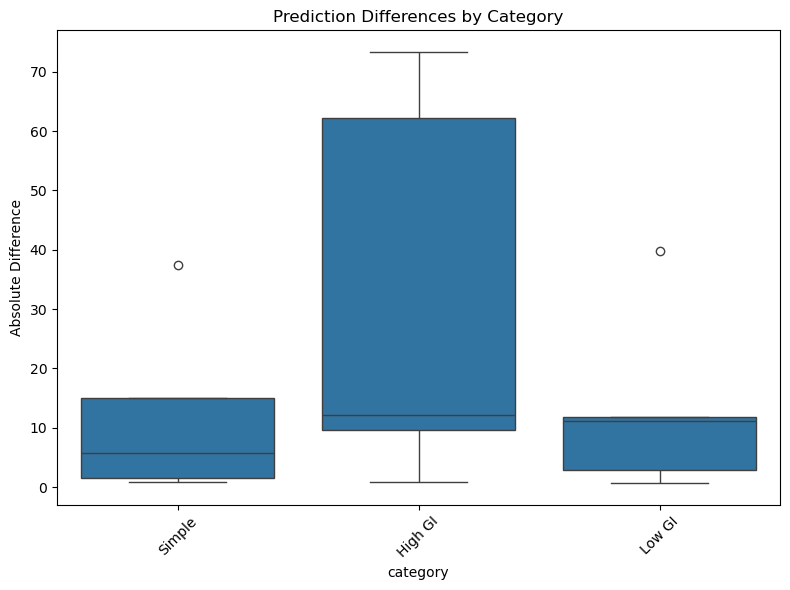

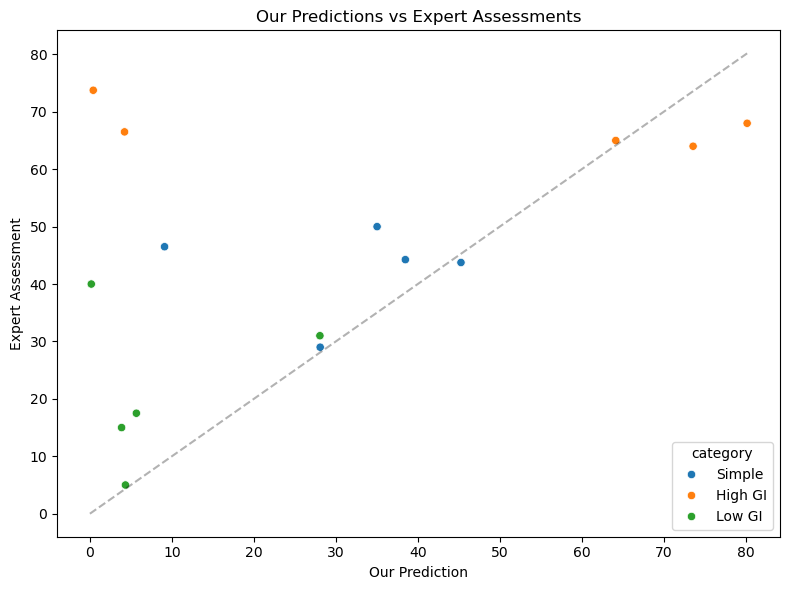

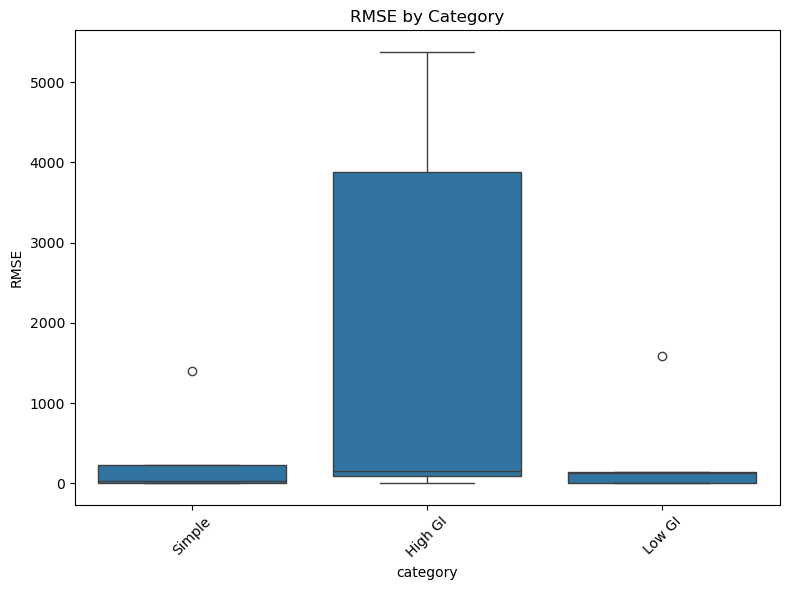

In [16]:
# --- Plot 1: Box plot of prediction differences by category ---
plt.figure(figsize=(8, 6))
sns.boxplot(x='category', y='prediction_difference', data=all_results)
plt.title('Prediction Differences by Category')
plt.xticks(rotation=45)
plt.ylabel('Absolute Difference')
plt.tight_layout()
plt.savefig(f'{plots_dir}/box_plot_prediction_difference.png')
plt.show()

# --- Plot 2: Scatter plot of predictions vs expert assessments ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=all_results, x='our_prediction', y='expert_assessment', hue='category')
max_val = max(all_results['our_prediction'].max(), all_results['expert_assessment'].max())
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.3)  # Diagonal line
plt.title('Our Predictions vs Expert Assessments')
plt.xlabel('Our Prediction')
plt.ylabel('Expert Assessment')
plt.tight_layout()
plt.savefig(f'{plots_dir}/scatter_plot_predictions_vs_experts.png')
plt.show()

# --- Plot 3: Box plot of RMSE by category ---
plt.figure(figsize=(8, 6))
sns.boxplot(x='category', y='rmse', data=all_results)
plt.title('RMSE by Category')
plt.xticks(rotation=45)
plt.ylabel('RMSE')
plt.tight_layout()
plt.savefig(f'{plots_dir}/box_plot_rmse.png')
plt.show()

## Analysis

In [17]:
print("\nOverall Statistics:")
print("=================")
print(f"Total recipes tested: {len(all_results)}")
print(f"Mean prediction difference: {all_results['prediction_difference'].mean():.2f}")
print(f"Root Mean Square Error (RMSE): {np.sqrt(all_results['rmse'].mean()):.2f}")
print(f"Standard deviation: {all_results['prediction_difference'].std():.2f}")
print(f"Max difference: {all_results['prediction_difference'].max():.2f}")
print(f"Min difference: {all_results['prediction_difference'].min():.2f}")

print("\nCategory-wise Statistics:")
print("======================")
for category in ['Simple', 'High GI', 'Low GI']:
    cat_results = all_results[all_results['category'] == category]
    print(f"\n{category}:")
    print(f"Number of recipes: {len(cat_results)}")
    print(f"Mean difference: {cat_results['prediction_difference'].mean():.2f}")
    print(f"RMSE: {np.sqrt(cat_results['rmse'].mean()):.2f}")
    print(f"Standard deviation: {cat_results['prediction_difference'].std():.2f}")


Overall Statistics:
Total recipes tested: 15
Mean prediction difference: 19.01
Root Mean Square Error (RMSE): 29.46
Standard deviation: 23.29
Max difference: 73.34
Min difference: 0.66

Category-wise Statistics:

Simple:
Number of recipes: 5
Mean difference: 12.11
RMSE: 18.21
Standard deviation: 15.21

High GI:
Number of recipes: 5
Mean difference: 31.64
RMSE: 43.58
Standard deviation: 33.51

Low GI:
Number of recipes: 5
Mean difference: 13.28
RMSE: 19.28
Standard deviation: 15.63


## Export Results

In [18]:
# Save detailed results to CSV
all_results.to_csv(f'{data_dir}/finetuned_model_results.csv', index=False)

# Save summary statistics
summary_stats = {
    'overall': {
        'total_recipes': len(all_results),
        'mean_difference': all_results['prediction_difference'].mean(),
        'rmse': np.sqrt(all_results['rmse'].mean()),
        'std_difference': all_results['prediction_difference'].std(),
        'max_difference': all_results['prediction_difference'].max(),
        'min_difference': all_results['prediction_difference'].min()
    },
    'by_category': {
        category: {
            'count': len(all_results[all_results['category'] == category]),
            'mean_difference': all_results[all_results['category'] == category]['prediction_difference'].mean(),
            'rmse': np.sqrt(all_results[all_results['category'] == category]['rmse'].mean()),
            'std_difference': all_results[all_results['category'] == category]['prediction_difference'].std()
        }
        for category in ['Simple', 'High GI', 'Low GI']
    }
}

with open(f'{data_dir}/summary_stats.json', 'w') as f:
    json.dump(summary_stats, f, indent=4)

print(f"\nResults have been saved to {results_dir}")


Results have been saved to test_results/finetuned/20250601_080735
